In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))
#%% Imports 
# https://www.ngdc.noaa.gov/stp/satellite/goes/
# https://stanford.edu/~shervine/projects/
import numpy as np


import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# %matplotlib inline
%matplotlib qt


TRAIN_TIME_WINDOW = 60 * 48 # Minutes * Hours
PREDICTION_TIME_GAP = 60 * 72 # Minutes * Hours

In [2]:
#%% Consts
X_FLARE = 1e-4
M_FLARE = 1e-5
#C_FLARE = 1e-6

FLARES = [X_FLARE,M_FLARE]

MIN_NOMINAL_DATA_VALUE = 1e+9

In [3]:
#%%
from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'qt')
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['figure.figsize'] = (10, 5)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Preprocessing

In [4]:
#%% Read years np array 
xray_avg_1m_numpy_data  = os.path.join('..','data','data_goes','xray_avg_1m_numpy_data')
# year_folders = ['2011','2012','2013','2014','2015','2016','2017','2018','2019']
year_folders = [str(a) for a in range(1998,2020)]
# year_folders = [str(a) for a in range(1998,2009)]
years_np_dict = {}
years_time_tag_dict = {}

# https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf
long_SWPC = 1 / 0.85

for year_label in year_folders:
    print('Trying load year {} numpy....'.format(year_label),end=' ')
    a_flux_file_path = os.path.join(xray_avg_1m_numpy_data,year_label+'.npy')
    if not os.path.isfile(a_flux_file_path) : 
        print('File : {}, Not Exist!'.format(a_flux_file_path))
        continue
    flux_matrix = np.load(a_flux_file_path,allow_pickle=True)
    #print('Year {} numpy loaded!'.format(year_label))
    
    val_col = flux_matrix.shape[1]-1
    
    years_np_dict[year_label] = flux_matrix[:,val_col]# * long_SWPC
    try:
        years_time_tag_dict[year_label] = flux_matrix[:,val_col-1]
    except: pass

Trying load year 1998 numpy.... Trying load year 1999 numpy.... Trying load year 2000 numpy.... Trying load year 2001 numpy.... Trying load year 2002 numpy.... Trying load year 2003 numpy.... Trying load year 2004 numpy.... Trying load year 2005 numpy.... Trying load year 2006 numpy.... Trying load year 2007 numpy.... Trying load year 2008 numpy.... Trying load year 2009 numpy.... Trying load year 2010 numpy.... Trying load year 2011 numpy.... Trying load year 2012 numpy.... Trying load year 2013 numpy.... Trying load year 2014 numpy.... Trying load year 2015 numpy.... Trying load year 2016 numpy.... Trying load year 2017 numpy.... Trying load year 2018 numpy.... Trying load year 2019 numpy.... 

In [5]:
#%% Plot each year data
def plot_years_dict(years_dict,FLARES=[]):
    colors = ['r','m']
    fig, axes = plt.subplots(len(years_np_dict),1,figsize=(15,50))
    plt.subplots_adjust(hspace=1)
    for ax,(year_label,data) in zip(axes,years_dict.items()):
        #data = years_np_dict[year_label]
        #print(year_label,np.min(data),np.where(np.isnan(data)))
        for idx,y in enumerate(FLARES) : ax.hlines(y,0,len(data),colors=colors[idx])
        ax.set_title(year_label)
        ax.plot(data)
        
#%% Flares Count

def flares_range_indecies_v2(year_data,x_thr = X_FLARE,m_thr = M_FLARE):
    
    for i in range(year_data.shape[0]-1):
        flare_type = -10
    
    
    

def flares_range_indecies(year_data,x_thr = X_FLARE,m_thr = M_FLARE):
    t_1 = year_data[1:]
    t = year_data[:-1]
    
    x_flux_start_index = np.where( np.bitwise_and(t <= x_thr , t_1 > x_thr))[0]
    x_flux_ends_index = np.where( np.bitwise_and(t > x_thr , t_1 <= x_thr))[0]

    x_flux_range = np.vstack((x_flux_start_index,x_flux_ends_index)).T
    
    m_flux_start_index = np.where( np.bitwise_and(t <= m_thr , t_1 > m_thr))[0]
    m_flux_ends_index = np.where( np.bitwise_and(t > m_thr , t_1 <= m_thr))[0]

    m_flux_range = np.vstack((m_flux_start_index,m_flux_ends_index)).T
    m_flux_range_indecies = [np.max(year_data[s:e]) < x_thr for s,e in m_flux_range]
    m_flux_range = m_flux_range[m_flux_range_indecies]
    
    return x_flux_range,m_flux_range

#plot_years_dict(years_np_dict,FLARES)

In [6]:

total_x = 0
total_m = 0
for lbl,year_data in years_np_dict.items():
    x_flux_range,m_flux_range = flares_range_indecies(year_data)
    print('Year {} : #X flares {}, #M flares {}'.format(lbl,x_flux_range.shape[0],m_flux_range.shape[0]),end=' |')
    
    diff_x = x_flux_range[:,1]-x_flux_range[:,0]
    diff_m = m_flux_range[:,1]-m_flux_range[:,0]
    print('Max Range(h): #X flares {:0.2f}, #M flares {:0.2f}'.format(np.max(diff_x,initial=-60)/60
                                                            ,np.max(diff_m,initial=-60)/60))
    total_x += x_flux_range.shape[0]
    total_m += m_flux_range.shape[0]
print('Total #X : {}, #M : {}'.format(total_x,total_m))

Year 1998 : #X flares 10, #M flares 58 |Max Range(h): #X flares 0.88, #M flares 1.77
Year 1999 : #X flares 4, #M flares 185 |Max Range(h): #X flares 0.18, #M flares 3.85
Year 2000 : #X flares 17, #M flares 229 |Max Range(h): #X flares 0.83, #M flares 3.42
Year 2001 : #X flares 23, #M flares 320 |Max Range(h): #X flares 2.05, #M flares 4.42
Year 2002 : #X flares 12, #M flares 239 |Max Range(h): #X flares 1.00, #M flares 5.45
Year 2003 : #X flares 23, #M flares 158 |Max Range(h): #X flares 1.58, #M flares 8.23
Year 2004 : #X flares 13, #M flares 123 |Max Range(h): #X flares 0.30, #M flares 2.97
Year 2005 : #X flares 19, #M flares 110 |Max Range(h): #X flares 1.83, #M flares 2.98
Year 2006 : #X flares 3, #M flares 8 |Max Range(h): #X flares 0.75, #M flares 0.57
Year 2007 : #X flares 0, #M flares 9 |Max Range(h): #X flares -1.00, #M flares 0.43
Year 2008 : #X flares 0, #M flares 1 |Max Range(h): #X flares -1.00, #M flares 0.33
Year 2009 : #X flares 0, #M flares 0 |Max Range(h): #X flares -

#### To 1D array

In [7]:
all_years_vector_data = np.array([])
all_years_ranges = []


for lbl,year_data in years_np_dict.items():

    all_years_ranges.append(len(year_data))
    all_years_vector_data = np.concatenate((all_years_vector_data,year_data))
    
all_years_vector_data = np.array(all_years_vector_data,dtype=np.float)
x_flux_range,m_flux_range = flares_range_indecies(all_years_vector_data)

diff_x = x_flux_range[:,1]-x_flux_range[:,0]
diff_m = m_flux_range[:,1]-m_flux_range[:,0]

all_years_vector_data.shape,diff_x.shape[0],diff_m.shape[0]


((10611058,), 171, 2196)

# PLOT 1D TIME SERIES AND SOLAR CYCLES

auto


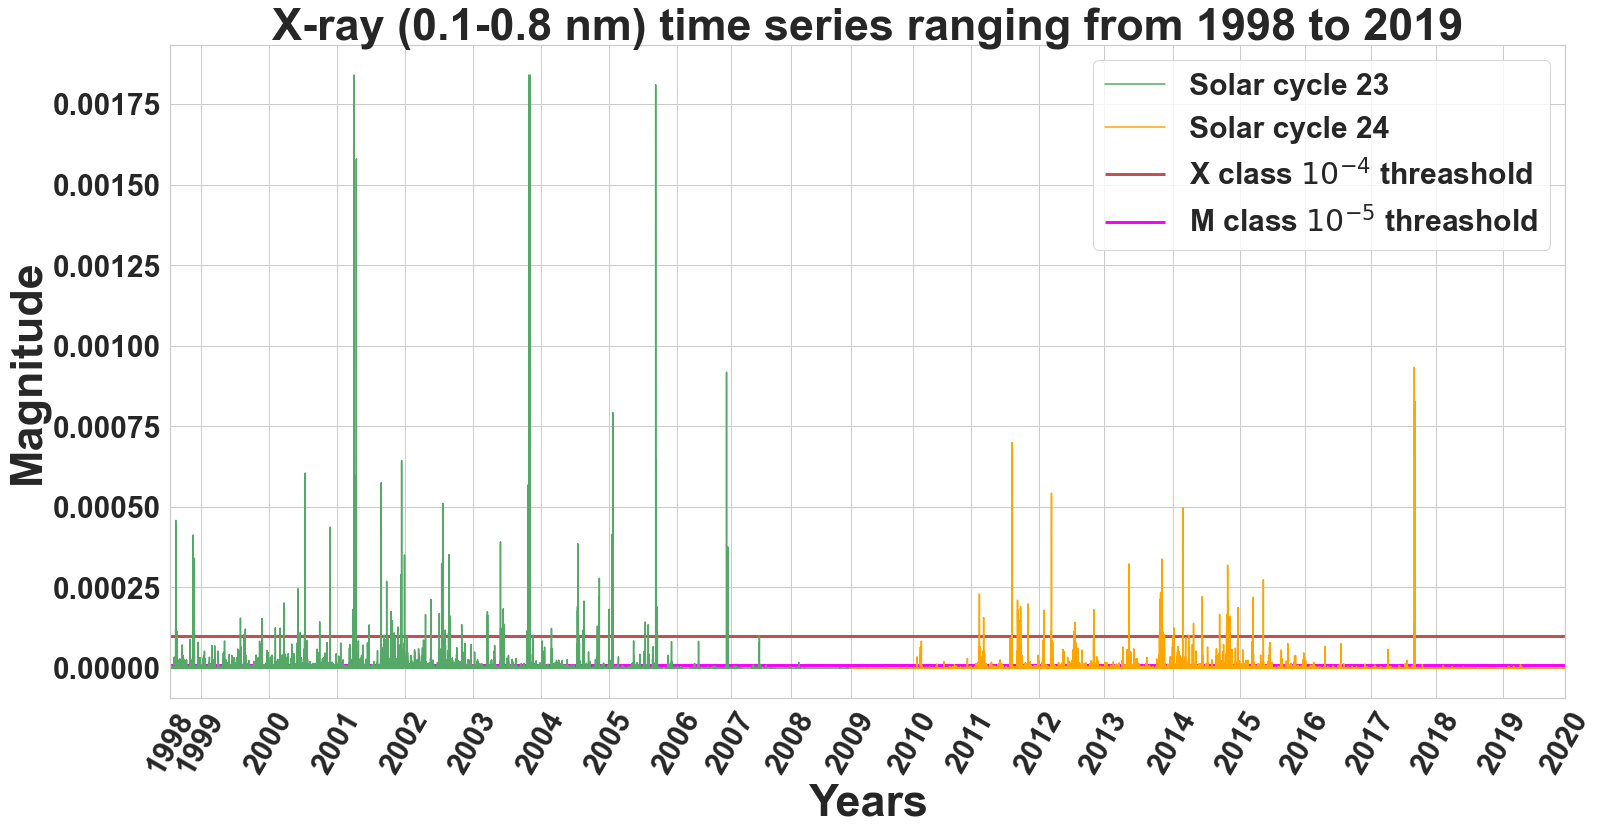

(10611058, 23)

In [8]:
#%matplotlib qt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")


data2plot = np.copy(all_years_vector_data)
# data2plot *= MIN_NOMINAL_DATA_VALUE
# data2plot = np.log(data2plot)

FONT_SIZE = 30



all_year_indecies = []
tmp_sum = 0
all_year_indecies.append(tmp_sum)
for r in all_years_ranges:
    tmp_sum += r
    all_year_indecies.append(tmp_sum)
all_year_indecies = np.asarray(all_year_indecies)
fig = plt.figure(figsize=(25,12))
# years = ['July\n1998']
ticks_years = np.arange(1998,2021,1)

# print(len(data2plot[0:int(all_year_indecies[11])]),len(np.arange(0,all_year_indecies[11])))q
cycle23_y = data2plot[0:int(all_year_indecies[11])]
cycle23_x = np.arange(0,all_year_indecies[11])

cycle24_y = data2plot[int(all_year_indecies[11]):int(all_year_indecies[len(all_year_indecies)-1])]
cycle24_x = np.arange(all_year_indecies[11],int(all_year_indecies[len(all_year_indecies)-1]))


plt.xticks(all_year_indecies,[str(a) for a in ticks_years],rotation=60,fontsize = FONT_SIZE,fontweight='bold')
plt.yticks(fontsize=FONT_SIZE,fontweight='bold')

## LOG
# plt.hlines(np.log(MIN_NOMINAL_DATA_VALUE*X_FLARE),0,len(all_years_vector_data),
#            colors='r',label=r'X class ${10}^{-4}$ threashold',linewidth=3)
# plt.hlines(np.log(MIN_NOMINAL_DATA_VALUE*M_FLARE),0,len(all_years_vector_data),
#            colors='magenta',label=r'M class ${10}^{-5}$ threashold',linewidth=3)


plt.hlines(X_FLARE,0,len(all_years_vector_data),
           colors='r',label=r'X class ${10}^{-4}$ threashold',linewidth=3)
plt.hlines(M_FLARE,0,len(all_years_vector_data),
           colors='magenta',label=r'M class ${10}^{-5}$ threashold',linewidth=3)

# plt.plot(data2plot,c='red', label='Solar cycle 24')
plt.plot(cycle23_x,cycle23_y,label='Solar cycle 23',color = 'g')
plt.plot(cycle24_x,cycle24_y,label='Solar cycle 24', color = 'orange')
# plt.plot(data2plot[:int(all_year_indecies[11])],c='y', label='Solar cycle 23')




# plt.title('Log scale X-ray (0.1-0.8 nm) time series ranging from 1998 to 2019',fontsize = FONT_SIZE*1.50,fontweight='bold')
plt.title('X-ray (0.1-0.8 nm) time series ranging from 1998 to 2019',fontsize = FONT_SIZE*1.50,fontweight='bold')
plt.ylabel('Magnitude',fontsize = FONT_SIZE*1.50,fontweight='bold')
plt.xlabel('Years',fontsize = FONT_SIZE*1.50,fontweight='bold')
plt.legend(prop={'weight':'bold','size':FONT_SIZE},loc=0)

plt.margins(x=0)
# plt.gca().set_aspect(100)
print(plt.gca().get_aspect())

plt.show()


# sns.lineplot(data=data2plot, palette="tab10", linewidth=2.5)


len(data2plot),len(all_year_indecies)


In [9]:
# PREPARE CICLES 23/24 data
cicle_23_vector_data = np.array([])
cicle_24_vector_data = np.array([])

cicle_23_years = [str(year) for year in range(1998,2009)]
cicle_24_years = [str(year) for year in range(2009,2020)]

for year_lbl in cicle_23_years:
    cicle_23_vector_data = np.concatenate((cicle_23_vector_data,years_np_dict[year_lbl]))
for year_lbl in cicle_24_years:
    cicle_24_vector_data = np.concatenate((cicle_24_vector_data,years_np_dict[year_lbl]))  

cicle_23_vector_data = np.array(cicle_23_vector_data,dtype=np.float)
cicle_24_vector_data = np.array(cicle_24_vector_data,dtype=np.float)

cicle_23_x_flux_range,cicle_23_m_flux_range = flares_range_indecies(cicle_23_vector_data)
cicle_24_x_flux_range,cicle_24_m_flux_range = flares_range_indecies(cicle_24_vector_data)

diff_23_x = cicle_23_x_flux_range[:,1]-cicle_23_x_flux_range[:,0]
diff_23_m = cicle_23_m_flux_range[:,1]-cicle_23_m_flux_range[:,0]
diff_24_x = cicle_24_x_flux_range[:,1]-cicle_24_x_flux_range[:,0]
diff_24_m = cicle_24_m_flux_range[:,1]-cicle_24_m_flux_range[:,0]

diff_23_x.shape[0],diff_23_m.shape[0],diff_24_x.shape[0],diff_24_m.shape[0]   

(124, 1440, 47, 756)

In [10]:
MAX_PRED_WINDOW = 60 * 96
MIN_PRED_WINDOW = 60 * 12

MAX_TRAIN_WINDOW = 60 * 48 

ADVANCE_12_HOURS = 60 * 12

VARIANCE_THR = 1e-20


def create_m_class_data(m_flux_range,years_vector_data):
    # Create M CLASS
    m_class_data = []
    for a,b in m_flux_range:
        sub_arr = years_vector_data[a:b]
        m = np.where(sub_arr == np.max(sub_arr))[0][0]
        flare_peak = m+a

    #     print(flare_peak)

        m_12h_range = years_vector_data[flare_peak - MAX_PRED_WINDOW : flare_peak + ADVANCE_12_HOURS]
        if np.max(m_12h_range) >= X_FLARE : continue

        try:
            start = flare_peak - MAX_PRED_WINDOW - MAX_TRAIN_WINDOW
            end = flare_peak
            m_class_part = years_vector_data[start:end]
            if np.var(years_vector_data[start:flare_peak-MIN_PRED_WINDOW]) <= VARIANCE_THR : continue
            m_class_data.append(m_class_part)
        except IndexError as ie: print(ie)
            
    return np.array(m_class_data)

def create_x_class_data(x_flux_range,years_vector_data):
    # Create X CLASS
    x_class_data = []
    for a,b in x_flux_range:
        sub_arr = years_vector_data[a:b]
        m = np.where(sub_arr==np.max(sub_arr))[0][0]
        flare_peak = m+a

        try:
            start = flare_peak - MAX_PRED_WINDOW - MAX_TRAIN_WINDOW
            end = flare_peak
            x_class_part = years_vector_data[start:end]
            if np.var(years_vector_data[start:flare_peak-MIN_PRED_WINDOW]) <= VARIANCE_THR : continue

            x_class_data.append(x_class_part)

        except IndexError as ie: print(ie)
    return np.array(x_class_data)
            
def create_neg_class_data(years_vector_data):
    neg_class_data = []
    for i in range(MAX_TRAIN_WINDOW,years_vector_data.shape[0] - MAX_PRED_WINDOW , MAX_PRED_WINDOW):
        quit_hours = years_vector_data[i:i+MAX_PRED_WINDOW+ADVANCE_12_HOURS]
        if np.max(quit_hours) < M_FLARE:
            neg_class_part = years_vector_data[i-MAX_TRAIN_WINDOW:i+MAX_PRED_WINDOW]
            if np.var(years_vector_data[i-MAX_TRAIN_WINDOW:i+MAX_PRED_WINDOW-MIN_PRED_WINDOW]) <= VARIANCE_THR : continue
            neg_class_data.append(neg_class_part)

    return np.array(neg_class_data )


In [11]:
# MAX_PRED_WINDOW = 60 * 96
# MIN_PRED_WINDOW = 60 * 12

# MAX_TRAIN_WINDOW = 60 * 48 

# ADVANCE_12_HOURS = 60 * 12

# VARIANCE_THR = 1e-20

# x_class_data = []
# m_class_data = []
# neg_class_data = []

# # Create M CLASS
# for a,b in m_flux_range:
#     sub_arr = all_years_vector_data[a:b]
#     m = np.where(sub_arr == np.max(sub_arr))[0][0]
#     flare_peak = m+a
    
# #     print(flare_peak)

#     m_12h_range = all_years_vector_data[flare_peak - MAX_PRED_WINDOW : flare_peak + ADVANCE_12_HOURS]
#     if np.max(m_12h_range) >= X_FLARE : continue
    
#     try:
#         start = flare_peak - MAX_PRED_WINDOW - MAX_TRAIN_WINDOW
#         end = flare_peak
#         m_class_part = all_years_vector_data[start:end]
#         if np.var(all_years_vector_data[start:flare_peak-MIN_PRED_WINDOW]) <= VARIANCE_THR : continue
#         m_class_data.append(m_class_part)
#     except IndexError as ie: print(ie)
        
# # Create X CLASS
# for a,b in x_flux_range:
#     sub_arr = all_years_vector_data[a:b]
#     m = np.where(sub_arr==np.max(sub_arr))[0][0]
#     flare_peak = m+a
    
#     try:
#         start = flare_peak - MAX_PRED_WINDOW - MAX_TRAIN_WINDOW
#         end = flare_peak
#         x_class_part = all_years_vector_data[start:end]
#         if np.var(all_years_vector_data[start:flare_peak-MIN_PRED_WINDOW]) <= VARIANCE_THR : continue
        
#         x_class_data.append(x_class_part)
        
#     except IndexError as ie: print(ie)        

# # Create Negative CLASS
# # Binary 1 - flare, 0 - no flare  
# for i in range(MAX_TRAIN_WINDOW,all_years_vector_data.shape[0] - MAX_PRED_WINDOW , MAX_PRED_WINDOW):
#     quit_hours = all_years_vector_data[i:i+MAX_PRED_WINDOW+ADVANCE_12_HOURS]
#     if np.max(quit_hours) < M_FLARE:
#         neg_class_part = all_years_vector_data[i-MAX_TRAIN_WINDOW:i+MAX_PRED_WINDOW]
#         if np.var(all_years_vector_data[i-MAX_TRAIN_WINDOW:i+MAX_PRED_WINDOW-MIN_PRED_WINDOW]) <= VARIANCE_THR : continue
#         neg_class_data.append(neg_class_part)

# x_class_data   = np.array(x_class_data   )
# m_class_data   = np.array(m_class_data   )
# neg_class_data = np.array(neg_class_data )

x_class_data = create_x_class_data(x_flux_range,all_years_vector_data)
m_class_data = create_m_class_data(m_flux_range,all_years_vector_data)
neg_class_data = create_neg_class_data(all_years_vector_data)

print(neg_class_data.shape,m_class_data.shape,x_class_data.shape)

cicle_23_x_class_data = create_x_class_data(cicle_23_x_flux_range,cicle_23_vector_data)
cicle_23_m_class_data = create_m_class_data(cicle_23_m_flux_range,cicle_23_vector_data)
cicle_23_neg_class_data = create_neg_class_data(cicle_23_vector_data)


cicle_24_x_class_data = create_x_class_data(cicle_24_x_flux_range,cicle_24_vector_data)
cicle_24_m_class_data = create_m_class_data(cicle_24_m_flux_range,cicle_24_vector_data)
cicle_24_neg_class_data = create_neg_class_data(cicle_24_vector_data)


print(cicle_23_x_class_data.shape,cicle_23_m_class_data.shape,cicle_23_neg_class_data.shape)
print(cicle_24_x_class_data.shape,cicle_24_m_class_data.shape,cicle_24_neg_class_data.shape)

(1057, 8640) (1522, 8640) (171, 8640)
(124, 8640) (972, 8640) (405, 8640)
(47, 8640) (550, 8640) (656, 8640)


In [12]:

def unite_classes_sizes(x_class_data,m_class_data,neg_class_data):
    # Create X class DATA
    x_m_neg_data = np.zeros((3,x_class_data.shape[0],x_class_data.shape[1]))
    np.random.seed(9927)

    x_m_indecies =  np.random.choice(m_class_data.shape[0],x_class_data.shape[0],replace=False)
    x_neg_indecies = np.random.choice(neg_class_data.shape[0],x_class_data.shape[0],replace=False)

#     print(x_m_indecies.shape,x_neg_indecies.shape)

    x_m_neg_data[0,:,:] = x_class_data
    x_m_neg_data[1,:,:] = m_class_data[x_m_indecies,:]
    x_m_neg_data[2,:,:] = neg_class_data[x_neg_indecies,:]


    # Create M,NEG class DATA

    remain_x_m_indecies = list(set(range(m_class_data.shape[0]))-set(x_m_indecies))
    remain_x_neg_indecies = list(set(range(neg_class_data.shape[0]))-set(x_neg_indecies))

    m_class_data_rem   = m_class_data[remain_x_m_indecies]
    neg_class_data_rem = neg_class_data[remain_x_neg_indecies]

    m_class_min = np.min((m_class_data_rem.shape[0],neg_class_data_rem.shape[0]))

    m_neg_data = np.zeros((2,m_class_min,m_class_data_rem.shape[1]))

    m_indecies = np.random.choice(m_class_data_rem.shape[0],m_class_min,replace=False)
    neg_indecies = np.random.choice(neg_class_data_rem.shape[0],m_class_min,replace=False)

    m_neg_data[0,:,:] = m_class_data_rem[m_indecies]
    m_neg_data[1,:,:] = neg_class_data_rem[neg_indecies]
    
    return x_m_neg_data,m_neg_data


(x_m_neg_data,m_neg_data) = unite_classes_sizes(x_class_data,m_class_data,neg_class_data)

print("1.random",x_m_neg_data.shape,m_neg_data.shape)

(cicle_23_x_m_neg_data,cicle_23_m_neg_data) = unite_classes_sizes(
    cicle_23_x_class_data,
    cicle_23_m_class_data,
    cicle_23_neg_class_data
)

print("2.cicle23",cicle_23_x_m_neg_data.shape,cicle_23_m_neg_data.shape)

(cicle_24_x_m_neg_data,cicle_24_m_neg_data) = unite_classes_sizes(
    cicle_24_x_class_data,
    cicle_24_m_class_data,
    cicle_24_neg_class_data
)
print("3.cicle24",cicle_24_x_m_neg_data.shape,cicle_24_m_neg_data.shape)
# print(cicle_23_x_m_neg_data.shape,cicle_23_m_neg_data.shape)

1.random (3, 171, 8640) (2, 886, 8640)
2.cicle23 (3, 124, 8640) (2, 281, 8640)
3.cicle24 (3, 47, 8640) (2, 503, 8640)


In [52]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib qt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as patches
#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
#https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

top = cm.get_cmap('Greens_r', 128)
bottom = cm.get_cmap('Wistia', 128)

newcolors = np.vstack(
    (top(np.linspace(0.5, 1, 1)),
    bottom(np.linspace(0.6,0.6, 1))
    ))
orangegreencmp = ListedColormap(newcolors, name='OrangeGreen')

greaycolors = cm.get_cmap('Greys', 128)(np.linspace(0, 1, 2))
greybinarycmp = ListedColormap(greaycolors, name='GreyBinary')


orangecmp = ListedColormap(orangegreencmp.colors[1], name='OrangeCmp')
# print(list(orangegreencmp.colors))

xx = m_neg_data[0].copy()
nn = m_neg_data[1].copy()

data2plot = np.concatenate((xx,nn),axis=0)#[:,:,0]
data2plot *= MIN_NOMINAL_DATA_VALUE
data2plot = np.log(data2plot)

indecies = np.random.choice(range(data2plot.shape[0]),data2plot.shape[0],replace=False)

data2plot = data2plot[indecies]

label2plot = np.array([1]*xx.shape[0]+[0]*nn.shape[0]).reshape(-1,1)[indecies]

print(data2plot.shape)

cycle_random_vec = np.random.randint(2, size=data2plot.shape[0]).reshape(-1,1)+23
cycle_random_vec_chrono = np.ones(data2plot.shape[0]).reshape(-1,1)+22

asp_ratio = 0.5#532/data2plot.shape[0] #1#0.612
# print(cycle_random_vec_chrono)
print(asp_ratio)

fig, axs = plt.subplots(1, 1)
fig.set_figheight(15)
fig.set_figwidth(15)
axs = [axs]
ax1 = axs[0]

fig.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=1, hspace=None)

ax1.set_title('M class vs None flare events frames', pad=20)
ax1.set_xlabel('Events frames sequence length (minutes)')
ax1.set_ylabel('Number of events')

impos = ax1.imshow(data2plot,aspect=4,cmap='inferno')

x_range = list(range(0,data2plot.shape[1],1000))+[data2plot.shape[1]]
y_range = list(range(0,data2plot.shape[0],250))[:-1]+[data2plot.shape[0]]

ax1.set_xticks(x_range)
ax1.set_yticks(y_range)
ax1.invert_yaxis()
ax1.invert_xaxis()
ax1.yaxis.tick_right()


input_windows_min = 48 * 60

colors = ['#1f77b4',
'#ff7f0e',
'#2ca02c',
'#d62728',
'#9467bd',
'#8c564b',
'#e377c2',
'#7f7f7f']
pred_gaps = [1,3,6,12,24,48,72,96]
frame_dict = {}
for gap in pred_gaps:
    start = gap * 60
    end = start + input_windows_min
    frame_dict[gap] = ((start,0),end,data2plot.shape[0])

lw = 10
for idx,(key,val) in enumerate(frame_dict.items()):
    
    rect = patches.Rectangle(val[0],val[1],val[2],linewidth=lw,edgecolor=colors[idx],facecolor='none'
                             ,label = '{} prediction frame'.format(key))
    # Add the patch to the Axes
    ax1.add_patch(rect)
    lw-=1
    


# ax2.xaxis.set_major_locator(plt.NullLocator())
# ax2.yaxis.set_major_locator(plt.NullLocator())

# ax2.set_title('Labels',pad=20)
# impos2 = ax2.imshow(label2plot,cmap=greybinarycmp)

# cbar = fig.colorbar(impos, ax=ax1,aspect=50* asp_ratio,ticks=[np.min(data2plot)]+list(np.arange(-10,10,1)))
# cbar = fig.colorbar(impos, ax=ax1,aspect=50* asp_ratio,ticks=list(np.arange(-10,10,1))+[np.max(data2plot)])


from_index =0
from_to = 20#20
cbar_range = list(np.arange(0,15,1))[from_index:from_to]
# print(cbar_range)
# print(list(range(0,6))[from_index:from_to])
cbar = fig.colorbar(impos, ax=ax1,ticks=[np.min(data2plot)]+cbar_range+[np.max(data2plot)])

cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Data values range')

# cbar2 = fig.colorbar(impos2, ax=ax2, ticks=[0,0.25,0.5,0.75,1])
# # cbar2.ax.set_yticklabels(['','0','','1',''])
# cbar2.ax.tick_params(labelsize=12)
# cbar2.ax.set_ylabel('Labels range')


for ax in list(axs)+[cbar.ax,cbar.ax]:
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
        item.set_fontweight('bold')
        
for ax in list(axs)+[cbar.ax,cbar.ax]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(28)
        item.set_fontweight('bold')
        
plt.legend(prop={'weight':'bold','size':24})
plt.show()

(1772, 8640)
0.5


In [21]:
def build_train_data_intervals(train_window,pred_window,data):
    
    n_types,amount,window = data.shape
    
    if window < train_window+pred_window : 
       raise Exception("train_window : {} + pred_window : {} to big for data window {}".format(train_window,pred_window,window))
    
    trimed = np.zeros((n_types,amount,train_window))
    
    for i in range(data.shape[0]):
        
        end = window - pred_window
        start = end - train_window
        
        trimed[i,:,:] = data[i,:,start:end] 
    
    return trimed

def build_train_data(trimed_data,labels = None,isOneHotEncoding = False):
    
    if labels is None:
        labels = range(trimed_data.shape[0])
        labels = np.array(labels)
        labels = labels.reshape(-1,1)
        
    if isOneHotEncoding:    
        ohe_labels = np.zeros((len(labels),len(labels)))
        for i in range(len(labels)):
            ohe_labels[i,i] = 1
            
        labels = ohe_labels

    X = trimed_data
    y = np.zeros((X.shape[0],X.shape[1],labels.shape[1]),dtype = int)
    
    for i in range(X.shape[0]):
        
        y[i,:,:] = int(labels[i])
    
    return X,y
        
        
    
td = build_train_data_intervals(10,20,x_m_neg_data)
X,y = build_train_data(td,isOneHotEncoding=0)

X.shape,y.shape,y[:,0,0]

((3, 171, 10), (3, 171, 1), array([0, 1, 2]))

#### train,prediction gap,hiiden layer size 

48,96,318

48,72,34 - 24/72

36,48,25

36,24,25

24,12,16

#### x_m_neg_data -> X class, M class, Neg class : (3, 171, 8640)


#### m_neg -> M class, Neg class : (2, 927, 8640)

In [22]:
# TRAIN_TIME_WINDOW = 60 * 48 # Minutes * Hours
# PREDICTION_TIME_GAP = 60 * 6 # Minutes * Hours

m_trimed = build_train_data_intervals(train_window=TRAIN_TIME_WINDOW,pred_window=PREDICTION_TIME_GAP,data=m_neg_data)
x_trimed = build_train_data_intervals(train_window=TRAIN_TIME_WINDOW,pred_window=PREDICTION_TIME_GAP,data=x_m_neg_data)

cicle_23_m_trimed = build_train_data_intervals(train_window=TRAIN_TIME_WINDOW,pred_window=PREDICTION_TIME_GAP,data=cicle_23_m_neg_data)
cicle_23_x_trimed = build_train_data_intervals(train_window=TRAIN_TIME_WINDOW,pred_window=PREDICTION_TIME_GAP,data=cicle_23_x_m_neg_data)

cicle_24_m_trimed = build_train_data_intervals(train_window=TRAIN_TIME_WINDOW,pred_window=PREDICTION_TIME_GAP,data=cicle_24_m_neg_data)
cicle_24_x_trimed = build_train_data_intervals(train_window=TRAIN_TIME_WINDOW,pred_window=PREDICTION_TIME_GAP,data=cicle_24_x_m_neg_data)


print("m_trimed : ",m_trimed.shape)
print("x_trimed : ",x_trimed.shape)

print("cicle_23_m_trimed : ",cicle_23_m_trimed.shape)
print("cicle_23_x_trimed : ",cicle_23_x_trimed.shape)

print("cicle_24_m_trimed : ",cicle_24_m_trimed.shape)
print("cicle_24_x_trimed : ",cicle_24_x_trimed.shape)

X_m,y_m = build_train_data(m_trimed,isOneHotEncoding=0)
X_x,y_x = build_train_data(x_trimed,isOneHotEncoding=0)
y_x[2,:,0] = 1

cicle_23_X_m,cicle_23_y_m = build_train_data(cicle_23_m_trimed,isOneHotEncoding=0)
cicle_23_X_x,cicle_23_y_x = build_train_data(cicle_23_x_trimed,isOneHotEncoding=0)
cicle_23_y_x[2,:,0] = 1

cicle_24_X_m,cicle_24_y_m = build_train_data(cicle_24_m_trimed,isOneHotEncoding=0)
cicle_24_X_x,cicle_24_y_x = build_train_data(cicle_24_x_trimed,isOneHotEncoding=0)
cicle_24_y_x[2,:,0] = 1


X,y = np.concatenate((X_m[0],X_m[1])),np.concatenate((y_m[0],y_m[1]))  # M vs None shape = -1x2
# X,y = np.concatenate((X_x[0],X_x[2])),np.concatenate((y_x[0],y_x[2])) # M vs X vs None shape = -1x3
# X,y = np.concatenate((X_x[0],X_x[1],X_x[2])),np.concatenate((y_x[0],y_x[1],y_x[2]))
# X,y = np.concatenate((X_x[0],X_x[2])),np.concatenate((y_x[0],y_x[2]))

# X class
# c23_X,c23_y = np.concatenate((cicle_23_X_x[0],cicle_23_X_x[1])),np.concatenate((cicle_23_y_x[0],cicle_23_y_x[1])) # X,M,NEG
# c24_X,c24_y = np.concatenate((cicle_24_X_x[0],cicle_24_X_x[1])),np.concatenate((cicle_24_y_x[0],cicle_24_y_x[1]))

# M class
c23_X,c23_y = np.concatenate((cicle_23_X_m[0],cicle_23_X_m[1])),np.concatenate((cicle_23_y_m[0],cicle_23_y_m[1]))
c24_X,c24_y = np.concatenate((cicle_24_X_m[0],cicle_24_X_m[1])),np.concatenate((cicle_24_y_m[0],cicle_24_y_m[1]))


X.shape,y.shape,y_x.shape

# c23_X.shape,c24_X.shape,X.shape

m_trimed :  (2, 886, 2880)
x_trimed :  (3, 171, 2880)
cicle_23_m_trimed :  (2, 281, 2880)
cicle_23_x_trimed :  (3, 124, 2880)
cicle_24_m_trimed :  (2, 503, 2880)
cicle_24_x_trimed :  (3, 47, 2880)


((1772, 2880), (1772, 1), (3, 171, 1))

#### Normalize and split

In [23]:
def norm_and_split(X,y,split_val = False,split_test=False,presentage = 0.3):
    data_X,data_y = X.copy(),y.copy()
    # data_X_class_x,data_Y_class_x = X_class_x.copy(),Y_class_x.copy()

    # Scale by noninal value
    data_X = data_X*MIN_NOMINAL_DATA_VALUE
    # data_X_class_x = data_X_class_x*MIN_NOMINAL_DATA_VALUE

    # Scale by log
    data_X = np.log(data_X)
    # data_X_class_x = np.log(data_X_class_x)

    #Train/Test split
    from sklearn.model_selection import train_test_split
    #Min Max scaler
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.utils import shuffle

    scaler = MinMaxScaler()
    _mean,_var = 0,1
    
    if not split_val and not split_test:
        print("No Validation, No Test!")
        X_train, y_train = shuffle(data_X ,data_y,random_state=57423)
        _mean,_var = np.mean(X_train),np.std(X_train)
        return (X_train,y_train),(_mean,_var)
    
    if (not split_val and split_test) or (split_val and not split_test):
        print("Validation Or Test!")
        X_train, X_test, y_train, y_test = train_test_split(data_X ,data_y, test_size=presentage,random_state=57423,shuffle=True)
        
        _mean,_var = np.mean(X_train),np.std(X_train)
        X_train = (X_train-_mean)/_var
        X_test = (X_test-_mean)/_var
        
        X_train = X_train.reshape(-1,TRAIN_TIME_WINDOW,1)
        X_test = X_test.reshape(-1,TRAIN_TIME_WINDOW,1)
        
        return (X_train,X_test,y_train,y_test),(_mean,_var)

    print("Validation and Test!")
    X_train, X_test, y_train, y_test = train_test_split(data_X ,data_y, test_size=presentage,random_state=57423,shuffle=True)
    X_model_train,X_model_validation,y_model_train,y_model_validation = train_test_split(X_train,y_train, test_size=presentage,random_state=93563379,shuffle=True)

    # random_state = 9374

    # X_train, X_test, y_train, y_test = train_test_split(
    #     data_X ,data_y, test_size=presentage,random_state=random_state,shuffle=True)

    # X_model_train,X_model_validation,y_model_train,y_model_validation = train_test_split(
    #     X_train,y_train, test_size=presentage,random_state=random_state,shuffle=True)



    # X_model_train = scaler.fit_transform(X_model_train)
    # X_model_validation = scaler.transform(X_model_validation)
    # X_test = scaler.transform(X_test)


    # STD normalization

    _mean,_var = np.mean(X_model_train),np.std(X_model_train)
    X_model_train = (X_model_train-_mean)/_var
    X_model_validation = (X_model_validation-_mean)/_var
    X_test = (X_test-_mean)/_var

    # data_X_class_x = (data_X_class_x-_mean)/_var

    X_model_train = X_model_train.reshape(-1,TRAIN_TIME_WINDOW,1)
    X_model_validation = X_model_validation.reshape(-1,TRAIN_TIME_WINDOW,1)
    X_test = X_test.reshape(-1,TRAIN_TIME_WINDOW,1)

    print('data_X             : ',data_X.shape);print()

    print('X_model_train      : ',X_model_train.shape[0]/2)
    print('X_model_validation : ',X_model_validation.shape[0]/2)
    print('X_test             : ',X_test.shape[0]/2);print()

    print('y_model_train      : ',y_model_train.shape)
    print('y_model_validation : ',y_model_validation.shape)
    print('y_test             : ',y_test.shape)
    
    return (X_model_train,X_model_validation,X_test,y_model_train,y_model_validation,y_test),(_mean,_var)

(X_model_train,X_model_validation,X_test,y_model_train,y_model_validation,y_test),(_mean,_var) = norm_and_split(X,y,split_val = 1,split_test=1)


#CHRONO SPLIT
# (X_model_train,X_model_validation,y_model_train,y_model_validation),(_mean,_var) = norm_and_split(c23_X,c23_y,split_val = 1,split_test=0)
# (X_test,y_test),(_,_) = norm_and_split(c24_X,c24_y,split_val = 0,split_test=0)
# X_test = (X_test-_mean)/_var

# RANDOM SPLIT
# (X_model_train,X_model_validation,X_test,y_model_train,y_model_validation,y_test),(_mean,_var) = norm_and_split(X,y,split_val = 1,split_test=1)

# np.min(X_model_train),np.max(X_model_train),np.mean(X_model_train),np.var(X_model_train)


# print('X_model_train      : ',X_model_train.shape[0]/2)
# print('X_model_validation : ',X_model_validation.shape[0]/2)
# print('X_test             : ',X_test.shape[0]/2);print()

print('------------------------------')
print('X_model_train      : ',X_model_train.shape)
print('X_model_validation : ',X_model_validation.shape)
print('X_test             : ',X_test.shape);print()

Validation and Test!
data_X             :  (1772, 2880)

X_model_train      :  434.0
X_model_validation :  186.0
X_test             :  266.0

y_model_train      :  (868, 1)
y_model_validation :  (372, 1)
y_test             :  (532, 1)
------------------------------
X_model_train      :  (868, 2880, 1)
X_model_validation :  (372, 2880, 1)
X_test             :  (532, 2880, 1)



1.0
[-1, 0, 1, 2]
[2, 3, 4, 5]


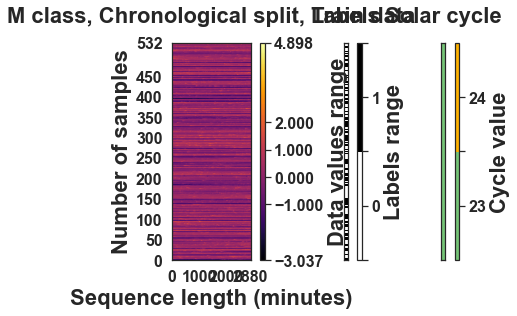

AxesImage(345.833,36;4.08722x217.44)


In [24]:
import seaborn as sns
sns.set_theme(style="white")

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
#https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

top = cm.get_cmap('Greens_r', 128)
bottom = cm.get_cmap('Wistia', 128)

newcolors = np.vstack(
    (top(np.linspace(0.5, 1, 1)),
    bottom(np.linspace(0.6,0.6, 1))
    ))
orangegreencmp = ListedColormap(newcolors, name='OrangeGreen')

greaycolors = cm.get_cmap('Greys', 128)(np.linspace(0, 1, 2))
greybinarycmp = ListedColormap(greaycolors, name='GreyBinary')


orangecmp = ListedColormap(orangegreencmp.colors[1], name='OrangeCmp')
# print(list(orangegreencmp.colors))



data2plot = X_test#[:,:,0]
label2plot = y_test

# data2plot = X_model_train[:,:,0]
# label2plot = y_model_train

cycle_random_vec = np.random.randint(2, size=data2plot.shape[0]).reshape(-1,1)+23
cycle_random_vec_chrono = np.ones(data2plot.shape[0]).reshape(-1,1)+22

asp_ratio = 532/data2plot.shape[0] #1#0.612
# print(cycle_random_vec_chrono)
print(asp_ratio)

fig, axs = plt.subplots(1, 3)
(ax1, ax2, ax3) = axs
fig.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=-0.5, hspace=None)


ax1.set_title('M class, Chronological split, Train data', pad=20)
ax1.set_xlabel('Sequence length (minutes)')
ax1.set_ylabel('Number of samples')


impos = ax1.imshow(data2plot,cmap='inferno',aspect=15.0 * asp_ratio)

x_range = list(range(0,data2plot.shape[1],1000))+[data2plot.shape[1]]
y_range = list(range(0,data2plot.shape[0],50))[:-1]+[data2plot.shape[0]]

ax1.set_xticks(x_range)
ax1.set_yticks(y_range)
ax1.invert_yaxis()

ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())

ax2.set_title('Labels',pad=20)
impos2 = ax2.imshow(label2plot,aspect=0.1* asp_ratio,cmap=greybinarycmp)


ax3.xaxis.set_major_locator(plt.NullLocator())
ax3.yaxis.set_major_locator(plt.NullLocator())

asp_ratio = 1#/asp_ratio

ax3.set_title('Solar cycle',pad=20)
impos3 = ax3.imshow(cycle_random_vec,aspect=0.1* asp_ratio,cmap=orangegreencmp)
# impos_chrono = ax3.imshow(cycle_random_vec_chrono,aspect=0.1* asp_ratio,cmap=orangecmp)
impos_chrono = ax3.imshow(cycle_random_vec_chrono,aspect=0.1* asp_ratio,cmap=orangegreencmp)

# cbar = fig.colorbar(impos, ax=ax1,aspect=50* asp_ratio,ticks=[np.min(data2plot)]+list(np.arange(-10,10,1)))
# cbar = fig.colorbar(impos, ax=ax1,aspect=50* asp_ratio,ticks=list(np.arange(-10,10,1))+[np.max(data2plot)])
from_index =2
from_to = 13#20
cbar_range = list(np.arange(-3,3,1))[from_index:from_to]
print(cbar_range)
print(list(range(0,6))[from_index:from_to])
cbar = fig.colorbar(impos, ax=ax1,aspect=50* asp_ratio,ticks=[np.min(data2plot)]+cbar_range+[np.max(data2plot)])

cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Data values range')

cbar2 = fig.colorbar(impos2, ax=ax2,aspect=50* asp_ratio, ticks=[0,0.25,0.5,0.75,1])
cbar2.ax.set_yticklabels(['','0','','1',''])
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.set_ylabel('Labels range')

cbar3 = fig.colorbar(impos3, ax=ax3,aspect=50* asp_ratio, ticks=[0,23.25,23.5,23.75,1])
# cbar3 = fig.colorbar(impos_chrono, ax=ax3,aspect=50* asp_ratio, ticks=[0,23.25,23.5,23.75,1])
cbar3.ax.set_yticklabels(['','23','','24',''])
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.set_ylabel('Cycle value')


# for ax in list(axs)+[cbar.ax]:
#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#                  ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(12)
#         item.set_fontweight('bold')

for ax in list(axs)+[cbar.ax,cbar2.ax,cbar3.ax]:
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
        item.set_fontweight('bold')
        
for ax in list(axs)+[cbar.ax,cbar2.ax,cbar3.ax]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(22)
        item.set_fontweight('bold')

plt.show()
print(impos3)

(5, 2880) (5, 2880) (5, 2880)


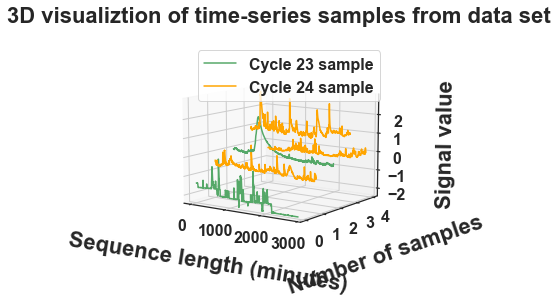

((2880,), (2880,), (2880,))

In [25]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=-55)

# ax.view_init(elev=10., azim=ii)
# Prepare arrays x, y, z

# ax.set_adjustable('datalim')
# ax.set_autoscaley_on(0)
ax.set_title('3D visualiztion of time-series samples from data set',pad=20)
ax.set_xlabel('Sequence length (minutes)',labelpad=20)
ax.set_ylabel('Number of samples',labelpad=20)
ax.set_zlabel('Signal value',labelpad=20)#Signal value


ax.set_yticks([0,1,2,3,4])#,['1','2','3','4','5'])

for item in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
    item.set_fontsize(16)
    item.set_fontweight('bold')
    
    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,ax.zaxis.label]):
    item.set_fontsize(22)
    item.set_fontweight('bold')

mz=X_model_train[15:20,:,0]
mx, my = np.meshgrid(np.arange(0, mz.shape[1],1), np.arange(0, mz.shape[0],1))
print(mx.shape,my.shape,mz.shape)

for idx,sig in enumerate(mz):
    x = np.arange(2880)
    y = np.ones(2880)*idx#*100
    z = sig 
    if y_model_train[idx][0] == 1:
        ax.plot(x, y, z , c='g',label='Cycle 23 sample')
    else:
        ax.plot(x, y, z , c='orange',label='Cycle 24 sample')
    

# fig.colorbar(p)
# ax.legend()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),prop={'weight':'bold','size':16},loc=0)

plt.show()
x.shape,y.shape,z.shape

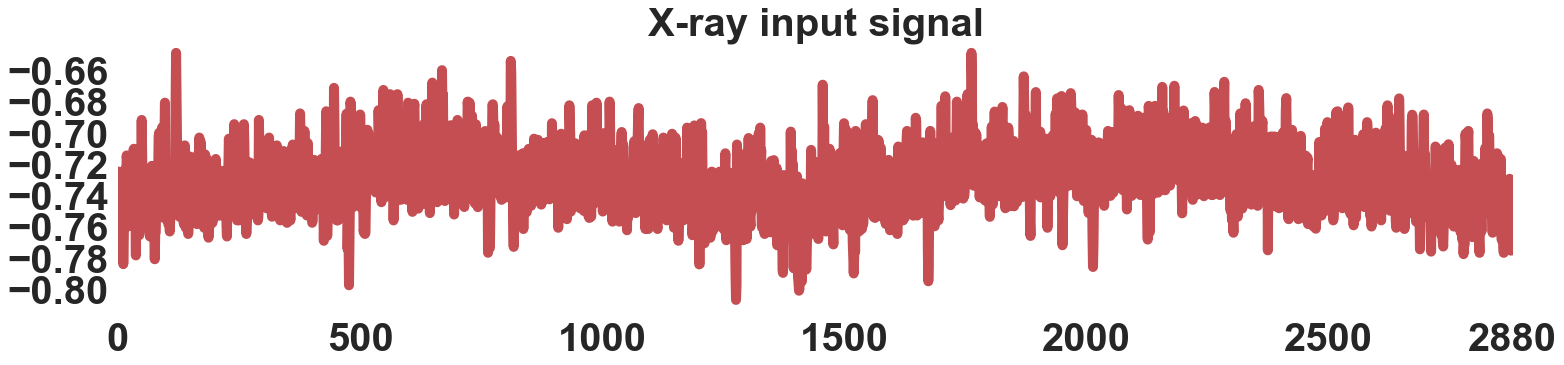

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_theme(style="white")

# plt.title('X-ray input signal',fontsize = 40,fontweight='bold')

n_plots = 1

for i in range(n_plots):
    ax=plt.subplot(n_plots, 1, i+1)
#     ax.axis("off")
    plt.title('X-ray input signal',fontsize = 40,fontweight='bold')
    plt.plot(X_model_train[i],c='r',label=str(y_model_train[i]),linewidth=10)
    plt.margins(x=0)
    for side in ax.spines:
#         print(side)
        ax.spines[side].set_visible(False)
    
    xticks = ax.get_xticks()
    xticks[-1] = 2880
    ax.set_xticks(xticks)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(40)
        item.set_fontweight('bold')
#     print(xticks)

#     plt.plot(X_m[1,i,:],c='g',label=str(y_model_train[i]))
#     plt.legend()
    

# plt.show()
# for i in range(n_plots):
#     plt.subplot(n_plots, 1, i+1)
#     plt.plot(X_test[i],c='r',label=str(y_test[i]))
#     plt.legend()
    

# plt.show()

## Statistics

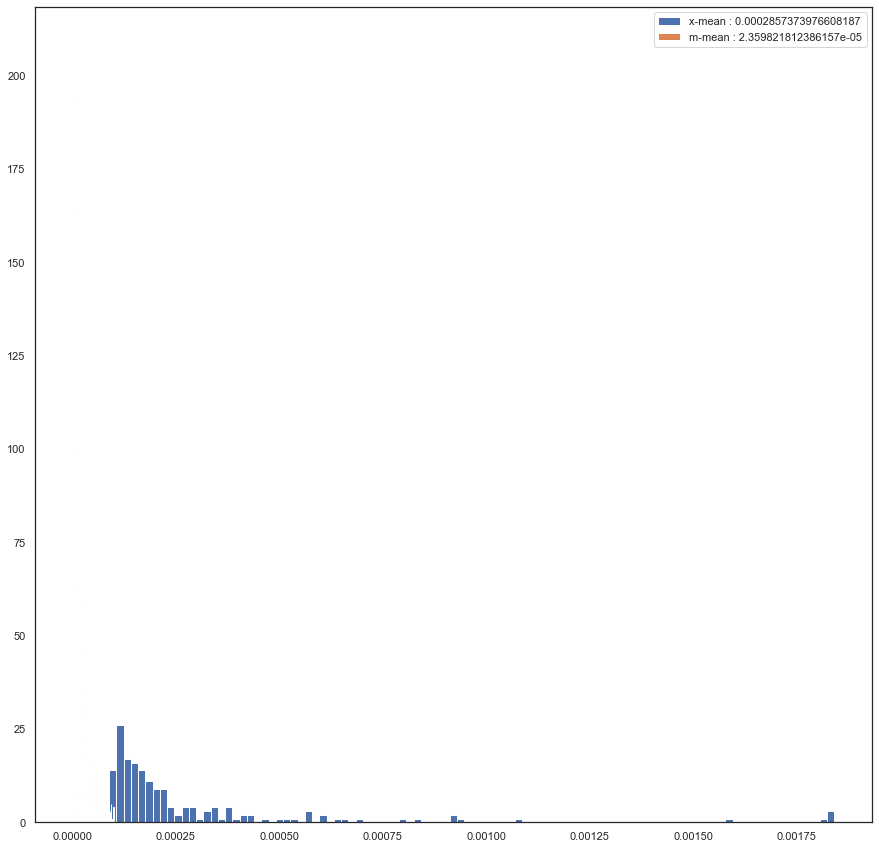

In [27]:
# # x_class_data = create_x_class_data(x_flux_range,all_years_vector_data)
# m_class_data = create_m_class_data(m_flux_range,all_years_vector_data)
%matplotlib inline
_ = plt.figure(figsize=(15,15))

x_hist = []
m_hist = []
for idx,(start,end) in enumerate(x_flux_range):
    x_val = np.max(all_years_vector_data[start:end])
    x_hist.append(x_val)

for idx,(start,end) in enumerate(m_flux_range):
    m_val = np.max(all_years_vector_data[start:end])
    m_hist.append(m_val)
    
x_hist = np.array(x_hist)
m_hist = np.array(m_hist)

plt.hist(x_hist,bins=100,label = 'x-mean : {}'.format(np.mean(x_hist)))
plt.hist(m_hist,bins=100,label = 'm-mean : {}'.format(np.mean(m_hist)))


plt.legend()
plt.show()



(30780,)


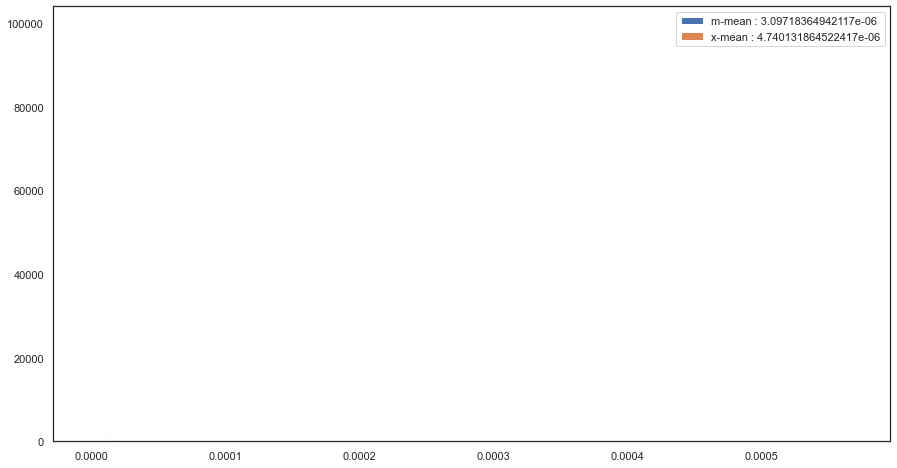

In [28]:


_ = plt.figure(figsize=(15,8))
x_hist = []
m_hist = []
for idx,(start,end) in enumerate(x_flux_range):
    x_val = all_years_vector_data[start-60*3:start]
    x_hist.append(x_val)

for idx,(start,end) in enumerate(m_flux_range):
    m_val = all_years_vector_data[start-60*3:start]
    m_hist.append(m_val)
    
x_hist = np.array(x_hist).reshape(-1)
m_hist = np.array(m_hist).reshape(-1)

print(x_hist.shape)

plt.hist(m_hist,bins=1000,label = 'm-mean : {}'.format(np.mean(m_hist)))
plt.hist(x_hist,bins=1000,label = 'x-mean : {}'.format(np.mean(x_hist)))

plt.legend()
plt.show()

## Machine Learning Tools

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_model_train[:,:,0])
pca_proj = pca.transform(X_model_train[:,:,0])
pca_proj.shape

colors = ['#e41a1c', '#377eb8']#, '#4daf4a']
colors = ['r', 'g']#, '#4daf4a']

#%matplotlib qt

#plt.scatter(pca_proj[:,0],pca_proj[:,2],color = np.array(colors)[y_model_train[:,0]])

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(1, figsize=(4, 3))
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
# ax.scatter(pca_proj[:, 0], pca_proj[:, 1], pca_proj[:, 2],color = np.array(colors)[y[:,0]])

In [30]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_model_train[:,:,0], y_model_train[:,0])


# lda_proj = clf.transform(X_model_validation[:,:,0])
# lda_pred = clf.predict(X_test[:,:,0])
# lda_proj.shape

# # plt.scatter(range(lda_proj.shape[0]),lda_proj[:,0],color = np.array(colors)[y_model_validation[:,0]])
# lda_pred,y_model_validation[:,0]

# sum(abs(lda_pred-y_test[:,0]))/y_test.shape[0]

In [31]:
# from sklearn import svm
# C=1.0
# clf = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
# clf.fit(X_model_train[:,:,0], y_model_train[:,0])

# svc_pred = clf.predict(X_test[:,:,0])

# sum(abs(svc_pred-y_test[:,0]))/y_test.shape[0]

## Model and Trainnig

In [42]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

tf.__version__

'2.2.0'

In [43]:
model_folder = 'test'
model_name = "CNN_T{}_P{}_m_vs_none".format(int(TRAIN_TIME_WINDOW/60),int(PREDICTION_TIME_GAP/60))
# model_name = "cnn_gru_general_2"
model = tf.keras.models.Sequential(name = model_name)

model.add(tf.keras.layers.Conv1D(filters=64,kernel_size=30,strides=1,padding='same',input_shape = (TRAIN_TIME_WINDOW,1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=15, strides=None, padding="same", data_format="channels_last"))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv1D(filters=256,kernel_size=15,strides=1,padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=5, strides=None, padding="same", data_format="channels_last"))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv1D(filters=512,kernel_size=5,strides=1,padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=None, padding="same", data_format="channels_last"))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv1D(filters=512,kernel_size=3,strides=1,padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=None, padding="same", data_format="channels_last"))
model.add(tf.keras.layers.Dropout(0.1))


# model.add(tf.keras.layers.Conv1D(filters=256,kernel_size=5,strides=1,padding='same'))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(0.1))

# model.add(tf.keras.layers.GRU(units=64,return_sequences=True,dropout = 0.1))
# model.add(tf.keras.layers.GRU(units=64,return_sequences=False,dropout = 0.1))
# model.add(tf.keras.layers.GRU(units=16,return_sequences=False,dropout = 0.1))

# model.add(tf.keras.layers.LSTM(units=4,return_sequences=0,dropout = 0))
# model.add(tf.keras.layers.LSTM(units=128,return_sequences=0,dropout = 0.1))

model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Activation('sigmoid'))
# model.add(tf.keras.layers.Dense(64))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(0.2))

# model.add(tf.keras.layers.Dense(32))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))

model.build(input_shape = (None,TRAIN_TIME_WINDOW,1))
_y = model(X_model_train[0].reshape(1,TRAIN_TIME_WINDOW,1))
model.summary()

dot_img_file = os.path.join('keras_models',model_folder,"model_architecture.png")
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


# serialize model to JSON
model_json = model.to_json()
model_json_path = os.path.join('keras_models',model_folder,model_name+".json")
with open(model_json_path, "w") as json_file:
    json_file.write(model_json)

_y.shape,model.name,X_model_train[0].shape#_y,

Model: "CNN_T48_P72_m_vs_none"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 2880, 64)          1984      
_________________________________________________________________
activation_5 (Activation)    (None, 2880, 64)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 192, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 192, 256)          246016    
_________________________________________________________________
activation_6 (Activation)    (None, 192, 256)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 256) 

(TensorShape([1, 2]), 'CNN_T48_P72_m_vs_none', (2880, 1))

In [44]:
y_model_train_cat = tf.keras.utils.to_categorical(y_model_train)
y_model_validation_cat = tf.keras.utils.to_categorical(y_model_validation)
y_test_cat = tf.keras.utils.to_categorical(y_test)
y_model_train_cat.shape,y_model_validation_cat.shape,y_test_cat.shape

((868, 2), (372, 2), (532, 2))

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"]) #Adam,SGD,RMSprop
#model.summary()

In [46]:
import os
import time
# model_name = model.name+"-{epoch:02d}-{val_accuracy:.2f}.hdf5"
file_name = model.name+".best.hdf5"
model_path = os.path.join('keras_models',model_folder,file_name)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,save_best_only=True,verbose=0,)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('keras_models',model_folder,model.name+'_log.csv'))

In [47]:
train_start_time = time.time()
if 1:
#     #--------------------- X class params--------------------------------
#     model.fit(X_model_train,y_model_train_cat,batch_size=8,epochs=100,verbose=1,
#               validation_data=(X_model_validation,y_model_validation_cat),callbacks=[checkpoint,csv_logger])
#     # --------------------- M class params--------------------------------
#     model.fit(X_model_train,y_model_train_cat,batch_size=32,epochs=100,verbose=1,
#               validation_data=(X_model_validation,y_model_validation_cat),callbacks=[checkpoint,csv_logger])
#     # --------------------- M vs X class params--------------------------------
    model.fit(X_model_train,y_model_train_cat,batch_size=16,epochs=75,verbose=1,
              validation_data=(X_model_validation,y_model_validation_cat),callbacks=[checkpoint,csv_logger])
print("Total train time : {}".format(time.time()-train_start_time))

Epoch 1/75
55/55 [==============================] - 3s 52ms/step - loss: 0.5194 - accuracy: 0.7765 - val_loss: 0.4336 - val_accuracy: 0.7957
Epoch 2/75
55/55 [==============================] - 3s 48ms/step - loss: 0.4307 - accuracy: 0.7995 - val_loss: 0.4322 - val_accuracy: 0.8038
Epoch 3/75
55/55 [==============================] - 3s 48ms/step - loss: 0.4247 - accuracy: 0.8053 - val_loss: 0.4231 - val_accuracy: 0.8118
Epoch 4/75
55/55 [==============================] - 2s 30ms/step - loss: 0.4294 - accuracy: 0.8065 - val_loss: 0.4321 - val_accuracy: 0.8253
Epoch 5/75
55/55 [==============================] - 3s 48ms/step - loss: 0.4220 - accuracy: 0.8099 - val_loss: 0.4205 - val_accuracy: 0.8280
Epoch 6/75
55/55 [==============================] - 3s 48ms/step - loss: 0.4169 - accuracy: 0.8099 - val_loss: 0.4176 - val_accuracy: 0.8333
Epoch 7/75
55/55 [==============================] - 3s 48ms/step - loss: 0.4128 - accuracy: 0.8203 - val_loss: 0.4128 - val_accuracy: 0.8333
Epoch 8/75
55

In [54]:
#model.summary()
model.load_weights(model_path)

In [55]:
import time
test_amount = X_test.shape[0]
start = time.time()
y_pred = model(X_test[:test_amount].reshape(-1,TRAIN_TIME_WINDOW,1))
t_eval = time.time()-start
y_pred.numpy().shape,y_test_cat[:test_amount].shape

((532, 2), (532, 2))

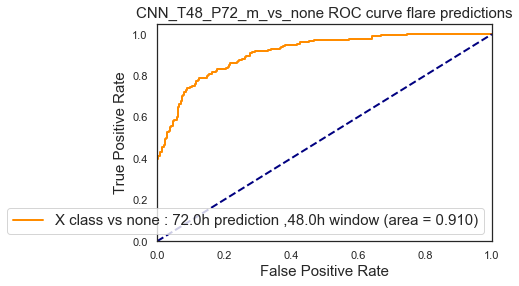

acc : 0.8157894736842105
prec : 0.8111888111888111
recall : 0.8405797101449275
f1 : 0.8256227758007118
[[232  44]
 [ 54 202]]
hss : 0.644927536231884
hss2 : 0.6473723000170077
tss  :0.6296422101449275
keras_models\test\CNN_T48_P72_m_vs_none_T48_P72_data_0.910.txt


In [56]:
from sklearn.metrics import roc_curve, auc,f1_score,precision_score,recall_score

import re
regex_whitespaces = re.compile(r"\s+", re.MULTILINE)

# choice = np.random.choice(t.shape[0],200,replace=False)
# t = t[choice]
# p = p[choice]

t = y_test_cat[:test_amount,0]
p = y_pred.numpy()[:,0]

fpr, tpr, _ = roc_curve(t, p)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label="X class vs none : "+str(PREDICTION_TIME_GAP / 60)+
                     'h prediction ,'+str(TRAIN_TIME_WINDOW / 60)
                     +'h window (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',fontsize = 15)
plt.title(str(model_name).split('(')[0]+' ROC curve flare predictions',fontsize = 15)
plt.legend(loc="lower right",fontsize = 15)
#plt.savefig(os.path.join('keras_models',model_name+'_T{}_P{}_data_'.format(int(TRAIN_TIME_WINDOW/60),int(PREDICTION_TIME_GAP/60))+'_roc_curve_'+'%0.3f'%roc_auc+'.png'))
plt.show()


# Additional metrics : PRECSION,RECALL,F1 score,HSS,HSS2,TSS
from sklearn.metrics import precision_score,recall_score,f1_score,multilabel_confusion_matrix,accuracy_score
accuracy = accuracy_score(t, p.round())
precision = precision_score(t, p.round())
recall = recall_score(t, p.round())
f1 = f1_score(t, p.round())

conf_matrix = multilabel_confusion_matrix(t, p.round())
TP = conf_matrix[0][0,0]
TN = conf_matrix[0][1,1]
FP = conf_matrix[0][1,0]
FN = conf_matrix[0][0,1]
P = np.sum(t)
N = len(t)-P
HSS = (TP+TN-N)/P
HSS2 = (2*(TP*TN)-(FN*FP))/(P*(FN+TN)+N*(TP+FP))
TSS = (TP/(TP+FN))-(FP/(FP+TN))

print("acc : {}\nprec : {}\nrecall : {}\nf1 : {}".format(accuracy,precision,recall,f1))
print(conf_matrix[0])
print("hss : {}\nhss2 : {}\ntss  :{}".format(HSS,HSS2,TSS))

model_result_file =  model_name+'_T{}_P{}_data_'.format(int(TRAIN_TIME_WINDOW/60),int(PREDICTION_TIME_GAP/60))+'%0.3f'%roc_auc+'.txt'
_file = os.path.join('keras_models',model_folder,model_result_file)

print(_file)
if 0:
    with open(_file,'w') as file:
        file.write(str(model_name)+'\n')
        file.write('PREDICTION_TIME_GAP : {}\n'.format(PREDICTION_TIME_GAP))
        file.write('TRAIN_TIME_WINDOW : {}\n'.format(TRAIN_TIME_WINDOW))
        file.write('TRAIN_SIZE : {}\n'.format(X_model_train.shape))
        file.write('TEST_SIZE : {}\n'.format(X_test.shape))
        file.write('EVAL_TIME(s) : {}\n'.format(t_eval))
        
        fpr_str = 'fpr={}\n'.format(str(fpr).replace('\n',''))
        fpr_str = regex_whitespaces.sub(",", fpr_str)
        file.write('{}\n'.format(fpr_str))
        tpr_str = 'tpr={}\n'.format(str(tpr).replace('\n',''))
        tpr_str = regex_whitespaces.sub(",", tpr_str)
        file.write('{}\n'.format(tpr_str))
        file.write('auc = {}\n'.format(str(roc_auc)))
        
        file.write('conf_matrix = {}\n'.format(str(conf_matrix[0]).replace('\n',',')))
        file.write('accuracy = {}\n'.format(str(accuracy)))
        file.write('precision = {}\n'.format(str(precision)))
        file.write('recall = {}\n'.format(str(recall)))
        file.write('f1_score = {}\n'.format(str(f1)))
        file.write('HSS = {}\n'.format(str(HSS)))
        file.write('HSS2 = {}\n'.format(str(HSS2)))
        file.write('TSS = {}\n'.format(str(TSS)))
        
        file.write('TP = {}\n'.format(str(TP)))
        file.write('TN = {}\n'.format(str(TN)))
        file.write('FP = {}\n'.format(str(FP)))
        file.write('FN = {}\n'.format(str(FN)))

In [ ]:

fpr_str = 'fpr={}\n'.format(str(fpr).replace('\n',''))
fpr_str = regex_whitespaces.sub(",", fpr_str)
print(fpr_str)

### Model weights and staff

In [ ]:
#return
model_folder_name = 'x_vs_none'
model_json_file_name = 'CNN_T48_P1_x_vs_none.json'
model_weights_file_name = 'CNN_T48_P1_x_vs_none.best.hdf5'
model_full_name = os.path.join("keras_models",model_folder_name,model_json_file_name)

model_weights = os.path.join("keras_models",model_folder_name,model_weights_file_name)

json_loaded_model = open(model_full_name,'r').read()

model = tf.keras.models.model_from_json(json_loaded_model)
model.load_weights(model_weights)

model.summary()

In [ ]:
x_test = X_test.reshape(-1,TRAIN_TIME_WINDOW,1)

y_pred = model(x_test)
y_true = y_test_cat

fpr, tpr, _ = roc_curve(y_true[:,0],y_pred[:,0])
roc_auc = auc(fpr, tpr)

#max M : index 21,3
#max X : index 13
#equal M,X : index 7


#fig = plt.figure(figsize=(15,15))
fig,ax = plt.subplots(3,2,figsize=(15,15))

ax[0,0].plot(x_test[7,: ],color='b')
ax[0,0].axis(ymin=-4,ymax=4)
ax[1,0].plot(x_test[13,:],color='r')
ax[1,0].axis(ymin=-4,ymax=4)
ax[2,0].plot(x_test[21,:],color='#f5b642')


ax[0,1].hist(x_test[7,:] ,bins=100,color='b'      ,label = 'mean : {0:.2f}'.format(np.mean(x_test[7,:])))

ax[0,1].legend()
ax[1,1].hist(x_test[13,:],bins=100,color='r'      ,label = 'mean : {0:.2f}'.format(np.mean(x_test[13,:])))

ax[1,1].legend()
ax[2,1].hist(x_test[21,:],bins=100,color='#f5b642',label = 'mean : {0:.2f}'.format(np.mean(x_test[21,:])))
ax[2,1].legend()



plt.show()

roc_auc,y_pred.shape,y_true.shape,y_pred[7,:],y_pred[13,:],y_pred[21,:]

In [ ]:
x_sample = x_test[7,: ].reshape(1,-1,1) 
m_sample = x_test[13,:].reshape(1,-1,1)

m_x_sample = x_test[51,:].reshape(1,-1,1)


sample = m_sample * 10#np.random.normal(size=(1,2880,1))#x_sample 

print("shape : ",m_x_sample.shape)
print("shape : ",m_sample.shape)
print("shape : ",x_sample.shape)

layer_outputs = [layer.output for layer in model.layers] 
# Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input



activations = activation_model.predict(sample) 
# # Returns a list of five Numpy arrays: one array per layer activation
layer_activation = activations[18]
print("layer_activation : ",layer_activation.shape,layer_activation)

print(len(activations))
for idx,layer in enumerate(activations):
    print(idx," : ",layer.shape)


fig,ax = plt.subplots(8,1,figsize=(15,25))

ax[0].axis(xmin=0,xmax=2880)
ax[0].plot(sample[0])

# ax[1].imshow(np.repeat(m_x_sample[0].T,repeats=300,axis=0), cmap='inferno',interpolation='nearest', aspect='auto')
ax[1].imshow(sample[0].T, cmap='inferno',interpolation='nearest', aspect='auto')





layer_indecies = [2-1,7-1,10-1,14-1]
for idx,layer_idx in enumerate(layer_indecies):
    ax[idx+2].imshow(activations[layer_idx][0, :, :].T, cmap='inferno',interpolation='nearest', aspect='auto')
    ax[idx+2].imshow(activations[layer_idx][0, :, :].T, cmap='inferno',interpolation='nearest',aspect='auto')
    ax[idx+2].imshow(activations[layer_idx][0, :, :].T, cmap='inferno',interpolation='nearest',aspect='auto')
    ax[idx+2].imshow(activations[layer_idx][0, :, :].T, cmap='inferno',interpolation='nearest',aspect='auto')

ax[6].axis(xmin=0,xmax=2560)
ax[6].plot(activations[16].T)#,cmap='inferno',interpolation='nearest',aspect='auto')
# ax[7].imshow(activations[18],cmap='inferno',interpolation='nearest',aspect='auto')
# ax[7].scatter(range(len(activations[18].T)),activations[18])# cmap='inferno',interpolation='nearest',aspect='auto')
ax[7].bar(range(len(activations[18].T)), activations[18][0])
ax[7].axis(ymin=0,ymax=1)
ax[7].axis(xmin=-3,xmax=3)
plt.show()




### Score matrix

In [ ]:
# LOAD MODEL
return
json_file_name = "cnn_gru_general_2.json"
model_weights_file = os.path.join("keras_models","cnn_gru_general_2.best.hdf5")
json_loaded_model = open(json_file_name,'r').read()

model = tf.keras.models.model_from_json(json_loaded_model)
model.load_weights(model_weights_file)

In [ ]:
#CREATE ROC MATRIX
from sklearn.metrics import roc_curve, auc,f1_score,precision_score,recall_score

roc_matrix_file_name = os.path.join("keras_models","cnn_gru_general.roc.mat_95x95")


max_hours = 144
try:
    roc_matrix = np.load(roc_matrix_file_name)
    print(roc_matrix_file_name+" ,loaded!")
except:
    print("New matrix created!")
    roc_matrix = np.zeros((max_hours,max_hours))

In [ ]:
return 
hours_factor = 60
# hours_shift = 48 

for train_window_index in range(max_hours-1):
    for train_gap_index in range(max_hours-1):
        
        train_window = (train_window_index+1)*hours_factor
        train_gap = (train_gap_index+1)*hours_factor
        
        start = time.time()
        _,_,X_test,_,_,y_test = prepare_m_class_dataset(train_window,train_gap)
        y_test_cat = tf.keras.utils.to_categorical(y_test) 
        y_pred = model(X_test.reshape(-1,train_window,1))
        t = y_test_cat[:,0]
        p = y_pred.numpy()[:,0]
        
        fpr, tpr, _ = roc_curve(t, p)
        roc_auc = auc(fpr, tpr)
        
        end_time = time.time()-start
        
        roc_matrix[train_window_index,train_gap_index] = roc_auc
        
        np.save(roc_matrix_file_name,roc_matrix)
        
        print("\n---------------------T_{},P_{},ROC_{}----------------------- time(s) : {}".format(train_window_index,train_gap_index,roc_auc,end_time))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.ndimage import gaussian_filter


try:
    roc_matrix = np.load(roc_matrix_file_name+".npy")
    print(roc_matrix_file_name+" ,loaded!")
    
    roc_matrix = roc_matrix[:-1,:-1]
    max_idx = np.where(roc_matrix ==  np.max(roc_matrix))
    best_roc = np.max(roc_matrix)
    best_t_window = max_idx[0]+1
    best_p_window = max_idx[1]+1
#     roc_matrix = np.flip(roc_matrix, 0)
#     roc_matrix = gaussian_filter(roc_matrix,3)
    
    
    fig = plt.figure(figsize=(25,25))

    ax = plt.subplot(111)
    im = ax.imshow(roc_matrix,cmap='inferno')

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    
#     ax.xaxis.tick_top()
    ax.xaxis.tick_bottom()
    
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=21)
    cbar.set_label('ROC values', rotation=270,fontweight='bold',fontsize=21,labelpad=25)

    ax.xaxis.set_tick_params(labelsize=21)
    ax.yaxis.set_tick_params(labelsize=21)
    ax.invert_yaxis()

    ax.set_title("ROC evaluation over different Predication/Train window sizes - \n (max ROC value - {:.2f} at train window of {} hours and prediction window {} hours)".format(best_roc,best_t_window,best_p_window)
                 ,fontsize = 25,pad = 30,fontweight = 'bold')

    ax.set_xlabel('Prediction window size',fontsize=21,labelpad=20,fontweight='bold')
    ax.set_ylabel('Train window size',fontsize=21,labelpad=20,fontweight='bold')
#     ax.set_zlabel('ROC - value',fontsize=21,labelpad=20,fontweight='bold')

    plt.show()
except Exception as e:
    print("No such file : ",e)
    pass



In [ ]:
np.max(roc_matrix),
max_idx = np.where(roc_matrix ==  np.max(roc_matrix))
max_idx,np.max(roc_matrix)

In [ ]:
%matplotlib qt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from matplotlib import cm
import random

from matplotlib import rc,rcParams
rc('font', weight='bold')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, roc_matrix.shape[0], 1)
X, Y = np.meshgrid(x, y)
# zs = np.array(fun(np.ravel(X), np.ravel(Y)))
# Z = zs.reshape(X.shape)

max_idx = np.where(roc_matrix ==  np.max(roc_matrix))
best_roc = np.max(roc_matrix)
best_t_window = max_idx[0]+1
best_p_window = max_idx[1]+1

surf = ax.plot_surface(X, Y, roc_matrix, cmap="inferno")

cbar = fig.colorbar(surf)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('ROC values', rotation=270,fontweight='bold',fontsize=16,labelpad=20)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)

ax.set_title("ROC evaluation over different Predication/Train window sizes - \n (max ROC value - {:.2f} at train window of {} hours and prediction window {} hours)".format(best_roc,best_t_window,best_p_window),fontsize = 20,pad = 30,fontweight = 'bold')

ax.set_xlabel('Prediction window size',fontsize=16,labelpad=20,fontweight='bold')
ax.set_ylabel('Train window size',fontsize=16,labelpad=20,fontweight='bold')
ax.set_zlabel('ROC - value',fontsize=16,labelpad=20,fontweight='bold')

plt.show()